In [6]:
import timm
from ultralytics import YOLO
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from matplotlib import pyplot as plt


def plot_image(image, bboxes):
    """
    绘制图像和bounding box
    """
    plt.imshow(image)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox["bbox"]
        plt.gca().add_patch(
            plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1, fill=False, color="red", linewidth=2
            )
        )
    plt.show()


0: 448x640 2 persons, 3 chairs, 2 potted plants, 2 dining tables, 2 tvs, 1 microwave, 2 refrigerators, 1 clock, 4 vases, 6.9ms
Speed: 0.8ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
19 [{'bbox': [5.427001953125, 166.39547729492188, 154.65811157226562, 262.5601806640625], 'score': np.float32(0.9300491), 'label': 62}, {'bbox': [289.53424072265625, 217.41552734375, 351.23455810546875, 319.33746337890625], 'score': np.float32(0.9134936), 'label': 56}, {'bbox': [361.362060546875, 219.06277465820312, 415.4993896484375, 319.5451965332031], 'score': np.float32(0.89086205), 'label': 56}, {'bbox': [558.2142333984375, 208.19482421875, 639.6876220703125, 287.65777587890625], 'score': np.float32(0.88752985), 'label': 62}, {'bbox': [550.1558837890625, 298.7564697265625, 586.7164306640625, 401.16339111328125], 'score': np.float32(0.8432288), 'label': 75}, {'bbox': [408.109375, 220.13475036621094, 441.5665283203125, 308.4940185546875], 'score': np.float32(0.82

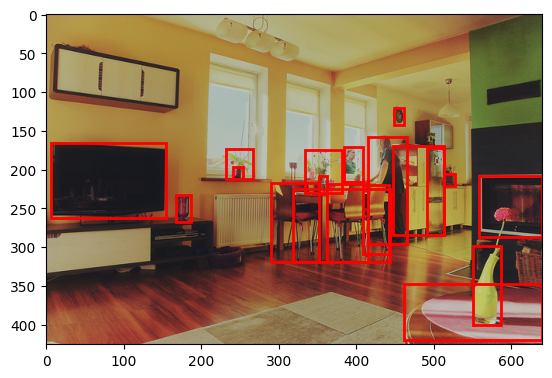

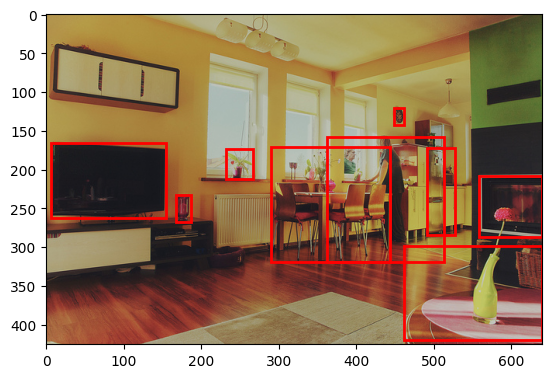

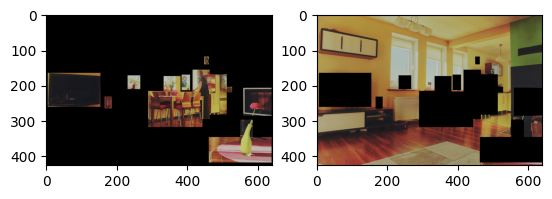

In [15]:
from PIL import Image
import numpy as np


def detect_objects_from_image(model, image_path: str):
    """
    从图像中检测对象，返回bounding box信息
    """
    model.eval()
    image = Image.open(image_path)
    results = model(image)
    # YOLO的results对象通常包含boxes属性
    bboxes = []
    for result in results:
        # result.boxes.xyxy为N x 4的张量，每行代表[x1, y1, x2, y2]
        if hasattr(result, "boxes") and hasattr(result.boxes, "xyxy"):
            boxes = result.boxes.xyxy.cpu().numpy()  # numpy数组
            scores = (
                result.boxes.conf.cpu().numpy()
                if hasattr(result.boxes, "conf")
                else None
            )
            labels = (
                result.boxes.cls.cpu().numpy() if hasattr(result.boxes, "cls") else None
            )
            for i, box in enumerate(boxes):
                bounding_box = {
                    "bbox": box.tolist(),
                    "score": scores[i] if scores is not None else None,
                    "label": int(labels[i]) if labels is not None else None,
                }
                bboxes.append(bounding_box)
    return bboxes


def crop_image_from_bbox(image_path: str, bboxes):
    """
    从图像中裁剪对象
    """
    image = Image.open(image_path).convert("RGB")
    cropped_images = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox["bbox"]
        cropped_image = image.crop((x1, y1, x2, y2))
        cropped_images.append(cropped_image)
    return cropped_images


def merge_overlapping_entities(bboxes, iou_threshold=0.3):
    """
    将有空间重叠的box合并成一个更大的entity box
    输入:
        bboxes: [{bbox: [x1, y1, x2, y2], score, label}, ...]
        iou_threshold: IOU超过此阈值认为有重叠进行合并
    输出:
        entities: [{entity: [x1, y1, x2, y2], scores: [], labels: []}, ...]
    """
    import numpy as np

    def compute_iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        unionArea = areaA + areaB - interArea
        if unionArea == 0:
            return 0
        return interArea / unionArea

    entities = []
    used = [False] * len(bboxes)

    for i, box1 in enumerate(bboxes):
        if used[i]:
            continue
        x1, y1, x2, y2 = box1["bbox"]
        entity_box = np.array([x1, y1, x2, y2], dtype=np.float32)
        entity_scores = [box1.get("score")]
        entity_labels = [box1.get("label")]

        used[i] = True
        # 合并所有与之重叠的
        for j, box2 in enumerate(bboxes):
            if i == j or used[j]:
                continue
            iou = compute_iou(entity_box, box2["bbox"])
            if iou > iou_threshold:
                x1_, y1_, x2_, y2_ = box2["bbox"]
                # 扩展entity_box包含新box
                entity_box[0] = min(entity_box[0], x1_)
                entity_box[1] = min(entity_box[1], y1_)
                entity_box[2] = max(entity_box[2], x2_)
                entity_box[3] = max(entity_box[3], y2_)
                entity_scores.append(box2.get("score"))
                entity_labels.append(box2.get("label"))
                used[j] = True
        entities.append(
            {
                "entity": entity_box.tolist(),
                "scores": entity_scores,
                "labels": entity_labels,
            }
        )
    return entities


def foreground_and_background(image_path: str, bboxes: list, H: int, W: int):
    """
    返回: foreground_img, background_img（均为PIL.Image）
    foreground_img 只保留前景区域（目标框内），其余为黑色
    background_img 只保留背景区域（非目标框），目标框内为黑色
    """
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    mask = np.zeros((H, W), dtype=np.uint8)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox["bbox"]
        # 转换为整数索引
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        mask[y1:y2, x1:x2] = 1

    # 前景只保留mask==1，其他为0
    fg_np = np.zeros_like(image_np)
    fg_np[mask == 1] = image_np[mask == 1]

    # 背景只保留mask==0，其他为0
    bg_np = np.zeros_like(image_np)
    bg_np[mask == 0] = image_np[mask == 0]

    foreground_img = Image.fromarray(fg_np)
    background_img = Image.fromarray(bg_np)
    return foreground_img, background_img


image_path = "data/coco/val2017/000000000139.jpg"
model = YOLO("yolov8x.pt")
bboxes = detect_objects_from_image(model, image_path)
cropped_images = crop_image_from_bbox(image_path, bboxes)
entities = merge_overlapping_entities(bboxes, iou_threshold=1e-6)
# Image.size 返回 (width, height)
W, H = Image.open(image_path).size
foreground_img, background_img = foreground_and_background(image_path, bboxes, H, W)

image = Image.open(image_path).convert("RGB")
print(len(bboxes), bboxes)
print(len(entities), entities)
print((len(bboxes) - len(entities)) / len(bboxes) * 100, "%")
plot_image(image, bboxes)
# 合并显示所有entity（即合并后的实体框）
plot_image(image, [{"bbox": entity["entity"]} for entity in entities])

plt.subplot(1, 2, 1)
plt.imshow(foreground_img)
plt.subplot(1, 2, 2)
plt.imshow(background_img)
plt.show()

In [10]:
import torch
from torch import nn

from src.models.attention.MultiHeadAttention import MultiHeadCrossAttention


class MoELayer(nn.Module):
    """
    Mixture-of-Experts (MoE) module for object-level representations.
    支持稀疏(sparse)与致密(dense)两种路由方式，并结合共享专家（shared expert）。
    """

    def __init__(
        self,
        input_dim,
        output_dim,
        num_experts=4,
        num_experts_shared=2,
        expert_hidden_dim=None,
        k=1,
        sparse=True,
        dropout=0.1,
    ):
        """
        input_dim: 输入向量维数
        output_dim: 输出向量维数
        num_experts: 专家数量
        num_experts_shared: 共享专家数量
        expert_hidden_dim: 专家mlp隐藏层, 若None则同input_dim
        k: sparse时每个输入选择的专家个数，dense时无效
        sparse: 是否采用稀疏路由（否则为dense全专家）
        dropout: Dropout概率，应用于每个专家内部
        """
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_experts = num_experts
        self.num_experts_shared = num_experts_shared
        self.k = k
        self.sparse = sparse
        if expert_hidden_dim is None:
            expert_hidden_dim = input_dim

        # 定义所有专家的mlp，每个专家包含Dropout
        self.experts = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(input_dim, expert_hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(expert_hidden_dim, output_dim),
                    nn.Dropout(dropout),
                )
                for _ in range(num_experts)
            ]
        )
        # 共享专家
        self.experts_shared = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(input_dim, expert_hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(expert_hidden_dim, output_dim),
                    nn.Dropout(dropout),
                )
                for _ in range(num_experts_shared)
            ]
        )
        # 门控网络，全部专家和共享专家都参与门控
        self.gate = nn.Linear(input_dim, num_experts + num_experts_shared)

    def forward(self, x):
        """
        x: shape (batch_size, input_dim)
        """
        gating_logits = self.gate(x)  # (batch, num_experts_shared + num_experts)
        gate_scores = nn.functional.softmax(gating_logits, dim=-1)  # 概率

        # 分离共享专家和非共享专家的对应门控权重
        shared_gate_scores = gate_scores[
            :, : self.num_experts_shared
        ]  # (batch, num_experts_shared)
        expert_gate_scores = gate_scores[
            :, self.num_experts_shared :
        ]  # (batch, num_experts)

        # 专家输出
        expert_outputs = torch.stack(
            [expert(x) for expert in self.experts], dim=1
        )  # (batch, num_experts, output_dim)

        # 共享专家输出（如果有共享专家）
        shared_outputs = None
        if self.num_experts_shared > 0:
            shared_outputs = torch.stack(
                [expert(x) for expert in self.experts_shared], dim=1
            )  # (batch, num_experts_shared, output_dim)
            # 门控加权共享专家输出
            shared_output = (shared_gate_scores.unsqueeze(-1) * shared_outputs).sum(
                dim=1
            )  # (batch, output_dim)
        else:
            shared_output = torch.zeros(
                x.shape[0], self.output_dim, device=x.device, dtype=expert_outputs.dtype
            )  # (batch, output_dim)

        if self.sparse:
            # 稀疏路由：每个样本最多选择k个普通专家（不包括共享专家），再加上共享专家加权输出
            topk_score, topk_idx = expert_gate_scores.topk(self.k, dim=-1)  # (batch, k)
            output = torch.zeros(
                x.shape[0], self.output_dim, device=x.device, dtype=expert_outputs.dtype
            )
            for b in range(x.shape[0]):
                for i, expert_id in enumerate(topk_idx[b]):
                    output[b] += topk_score[b, i] * expert_outputs[b, expert_id]
            output = output + shared_output  # 加上共享专家部分
            return output
        else:
            # 致密路由：全部专家+共享专家加权求和
            if self.num_experts_shared > 0 and shared_outputs is not None:
                all_outputs = torch.cat(
                    [shared_outputs, expert_outputs], dim=1
                )  # (batch, num_experts_shared + num_experts, output_dim)
            else:
                all_outputs = expert_outputs  # (batch, num_experts, output_dim)
            gate_scores_unsq = gate_scores.unsqueeze(
                -1
            )  # (batch, num_experts_shared + num_experts, 1)
            output = (all_outputs * gate_scores_unsq).sum(dim=1)
            return output


class ObjectMoELayer(nn.Module):
    """
    基于MoELayer实现的 object-level MoE 层，对每个 object 先用 MoE 表示，再通过 cross-attention 关联各 object，最后加FFN（含dropout）。
    """

    def __init__(
        self,
        input_dim,
        output_dim,
        num_experts=4,
        num_experts_shared=2,
        expert_hidden_dim=None,
        k=1,
        sparse=True,
        dropout=0.1,
        ffn_hidden_dim=None,
        cross_attn_heads=1,
        cross_attn_dropout=0.0,
    ):
        super().__init__()
        # 基于MoELayer实现
        self.moe = MoELayer(
            input_dim=input_dim,
            output_dim=output_dim,
            num_experts=num_experts,
            num_experts_shared=num_experts_shared,
            expert_hidden_dim=expert_hidden_dim,
            k=k,
            sparse=sparse,
            dropout=dropout,
        )
        # 正确引用MultiHeadCrossAttention(项目已有)
        self.cross_attn = MultiHeadCrossAttention(
            embed_dim=output_dim,
            num_heads=cross_attn_heads,
            attn_dropout=cross_attn_dropout,
        )
        # FFN部分
        ffn_hidden_dim = ffn_hidden_dim or (output_dim * 4)
        self.ffn = nn.Sequential(
            nn.Linear(output_dim, ffn_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_hidden_dim, output_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x, context=None):
        """
        x: shape = (B, N_OBJ, ..., D)，即除N_OBJ和D外可以有任意数量的中间维度
        context: (可选) (B, M, output_dim)，用于作为cross-attention的key/value，若为None则degrade为self-attention。
        输出: shape = (B, N_OBJ, ..., output_dim)
        """
        if x.dim() < 3:
            raise ValueError(f"x must be at least 3D (B, N_OBJ, D), got {x.shape}")

        B, N_OBJ = x.shape[:2]
        other_shape = x.shape[2:-1]  # ... 部分
        D = x.shape[-1]

        num_items = 1
        for s in other_shape:
            num_items *= s
        # 将所有object维度flatten，方便批量处理
        x_flat = x.view(B * N_OBJ * num_items, D)
        out_flat = self.moe(x_flat)  # (B*N_OBJ*num_items, output_dim)
        # 恢复到 (B, N_OBJ, ..., output_dim)
        out_shape = (B, N_OBJ, *other_shape, -1)
        obj_feat = out_flat.view(
            B, N_OBJ * num_items, -1
        )  # (B, N_OBJ*num_items, output_dim)

        if context is not None:
            if context.shape[0] != B or context.shape[2] != obj_feat.shape[2]:
                raise ValueError("context shape must be (B, M, output_dim)")
            query = obj_feat
            key = context
            value = context
        else:
            query = obj_feat
            key = obj_feat
            value = obj_feat

        rel_out, _ = self.cross_attn(
            query, key, value
        )  # (B, N_OBJ*num_items, output_dim)
        rel_out = rel_out.view(*out_shape)  # (B, N_OBJ, ..., output_dim)
        ffn_out = self.ffn(rel_out)
        return ffn_out


class EntityMoELayer(nn.Module):
    """
    EntityMoELayer
    该层以entity作为最小单元，每个entity内部包含多个object。输入形状应为 (B, N_ENTITY, N_OBJ_PER_ENTITY, D)
    用法:
      - entity粒度的Gating，entity内部多个object整体送入MoE并聚合表示
      - 可结合MoELayer
    """

    def __init__(
        self,
        input_dim,
        output_dim,
        num_experts=4,
        num_experts_shared=0,
        expert_hidden_dim=None,
        k=1,
        sparse=True,
        dropout=0.1,
        ffn_hidden_dim=None,
        cross_attn_heads=1,
        cross_attn_dropout=0.0,
    ):
        super().__init__()
        # 基于MoELayer，每个entity整体送入MoE
        self.moe = MoELayer(
            input_dim=input_dim,
            output_dim=output_dim,
            num_experts=num_experts,
            num_experts_shared=num_experts_shared,
            expert_hidden_dim=expert_hidden_dim,
            k=k,
            sparse=sparse,
            dropout=dropout,
        )
        # 正确引用MultiHeadCrossAttention
        self.cross_attn = MultiHeadCrossAttention(
            embed_dim=output_dim,
            num_heads=cross_attn_heads,
            attn_dropout=cross_attn_dropout,
        )
        ffn_hidden_dim = ffn_hidden_dim or (output_dim * 4)
        self.ffn = nn.Sequential(
            nn.Linear(output_dim, ffn_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_hidden_dim, output_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x, context=None):
        """
        x: shape = (B, N_ENTITY, N_OBJ_PER_ENTITY, D)
        context: (可选) (B, M, output_dim)，用于作为cross-attention的key/value，若为None则degrade为self-attention。
        输出: shape = (B, N_ENTITY, output_dim)
        加权聚合entity内部objects, 对EntityFeats进行加权
        """
        if x.dim() != 4:
            raise ValueError(
                f"x should be 4D (B, N_ENTITY, N_OBJ_PER_ENTITY, D), got {x.shape}"
            )

        B, N_ENTITY, N_OBJ_PER_ENTITY, D = x.shape

        # ---- Step 1: 对entity内部objects做加权聚合 ----
        attn_linear = getattr(self, "attn_linear", None)
        if attn_linear is None or attn_linear.in_features != D:
            # run-time实例化防止N_OBJ_PER_ENTITY未定，新加属性
            self.attn_linear = nn.Linear(D, 1, bias=False).to(x.device)
        logits = self.attn_linear(x)  # (B, N_ENTITY, N_OBJ_PER_ENTITY, 1)
        weights = torch.softmax(logits, dim=2)  # (B, N_ENTITY, N_OBJ_PER_ENTITY, 1)
        x_agg = (x * weights).sum(dim=2)  # (B, N_ENTITY, D)
        # ------------------------------------------------

        x_flat = x_agg.view(B * N_ENTITY, D)
        moe_out = self.moe(x_flat)  # (B*N_ENTITY, output_dim)
        entity_feat = moe_out.view(B, N_ENTITY, -1)  # (B, N_ENTITY, output_dim)

        # entity间做cross-attention建模
        if context is not None:
            if context.shape[0] != B or context.shape[2] != entity_feat.shape[2]:
                raise ValueError("context shape must be (B, M, output_dim)")
            query = entity_feat
            key = context
            value = context
        else:
            query = entity_feat
            key = entity_feat
            value = entity_feat

        rel_out, _ = self.cross_attn(query, key, value)  # (B, N_ENTITY, output_dim)
        ffn_out = self.ffn(rel_out)  # (B, N_ENTITY, output_dim)
        return ffn_out

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm


class VitEntityMoEClassifier(nn.Module):
    """
    使用EntityMoELayer + ViT backbone (timm) 进行分类
    """

    def __init__(
        self,
        num_classes,
        vit_model_name="vit_base_patch16_224",
        pretrained=True,
        moe_output_dim=192,
        num_entities=4,
        num_objects_per_entity=8,
        moe_hidden_dim=256,
        moe_num_experts=8,
        moe_dropout=0.1,
        attn_head=4,
    ):
        super().__init__()
        # 使用timm加载ViT作为特征提取器
        self.vit = timm.create_model(
            vit_model_name,
            pretrained=pretrained,
            num_classes=0,  # 移除分类头，仅作为特征提取器
        )
        self.embed_dim = self.vit.embed_dim

        # EntityMoELayer相关参数
        self.num_entities = num_entities
        self.num_objects_per_entity = num_objects_per_entity
        self.entity_moe = EntityMoELayer(
            input_dim=self.embed_dim,
            output_dim=moe_output_dim,
            num_experts=moe_num_experts,
            expert_hidden_dim=moe_hidden_dim,  # 修正参数名
            dropout=moe_dropout,
            cross_attn_heads=attn_head,  # 修正参数名
        )
        self.classifier = nn.Linear(moe_output_dim * num_entities, num_classes)

    def forward(self, x):
        """
        x: (B, 3, H, W) or (B, N, 3, H, W)
        支持单张和多张图片（N为多视图或分片情况）
        """
        # 支持输入为(B, 3, H, W)或(B, N, 3, H, W)
        if x.ndim == 5:
            # (B, N, 3, H, W) -> (B*N, 3, H, W)
            B, N, C, H, W = x.shape
            x_reshape = x.reshape(B * N, C, H, W)
            x_vit = self.vit.forward_features(
                x_reshape
            )  # (B*N, n_patches+1, embed_dim)
            x_vit = x_vit.unsqueeze(0).reshape(
                B, N, x_vit.shape[1], x_vit.shape[2]
            )  # (B, N, n_patches+1, D)
        elif x.ndim == 4:
            # (B, 3, H, W)
            x_vit = self.vit.forward_features(x).unsqueeze(1)  # (B, 1, n_patches+1, D)
            N = 1
        else:
            raise ValueError(f"输入张量维度期望为4或5, 得到: {x.ndim}")

        # x_vit: (B, N, n_patches+1, D)
        # 移除cls token，只保留patch tokens
        x_vit = x_vit[:, :, 1:, :]  # (B, N, n_patches, D)
        n_patches = x_vit.shape[2]
        # 将所有N视图的patch拼接（按N方向展平到patch维度），方便后续均匀切分
        x_vit = x_vit.reshape(x_vit.shape[0], -1, x_vit.shape[3])  # (B, N*n_patches, D)
        total_patches = x_vit.shape[1]

        assert (
            self.num_entities * self.num_objects_per_entity <= total_patches
        ), f"entity*obj per entity ({self.num_entities * self.num_objects_per_entity}) 必须 ≤ patch总数 ({total_patches})"

        # 均匀切片为entity
        x_entities = []
        for i in range(self.num_entities):
            st = i * self.num_objects_per_entity
            ed = st + self.num_objects_per_entity
            x_entities.append(
                x_vit[:, st:ed, :].unsqueeze(1)  # (B, 1, num_objects_per_entity, D)
            )
        x_entities = torch.cat(
            x_entities, dim=1
        )  # (B, num_entities, num_objects_per_entity, D)

        # 送进EntityMoELayer
        entity_reps = self.entity_moe(x_entities)  # (B, num_entities, moe_output_dim)

        # 拼接聚合后分类
        flat_entity = entity_reps.reshape(entity_reps.shape[0], -1)
        out = self.classifier(flat_entity)  # (B, num_classes)
        return out


# 用法示例:
model = VitEntityMoEClassifier(num_classes=10).cpu()
x = torch.randn(2, 3, 3, 224, 224)
logits = model(x)
print(f"输出形状: {logits.shape}")
print(f"模型参数量: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")

输出形状: torch.Size([2, 10])
模型参数量: 88.23M


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm


# 用法示例:
model = VitEntityMoEClassifier(num_classes=10).cpu()
x = torch.randn(2, 3, 3, 224, 224)
logits = model(x)
print(f"输出形状: {logits.shape}")
print(f"模型参数量: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")